In [1]:
!pip install -q lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 9.2 MB/s eta 0:00:00


In [2]:
# Lending Club Risk Analysis - Complete Implementation
# Professional Data Science Notebook for Comprehensive Risk Analytics

# =============================================================================
# IMPORTS AND SETUP
# =============================================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

# Set Plotly renderer for Kaggle compatibility
pio.renderers.default = 'iframe'

# Survival Analysis Libraries
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

# Machine Learning Libraries
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from scipy import sparse
import tensorflow as tf

# Utility Libraries
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict
import time

print("All libraries imported successfully")

2025-08-13 13:27:38.359750: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755091658.582749      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755091658.651445      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


All libraries imported successfully


In [3]:
# =============================================================================
# DATA LOADING AND INITIAL PREPROCESSING
# =============================================================================

# Load the complete dataset
df = pd.read_parquet('/kaggle/input/lending-club-dataset-proper-formatted/lending_club_accepted_systematic.parquet')

# Create backup copy
original_df = df.copy()

# Rename columns for clarity
df = df.rename(columns={
    "loan_amnt": "loan_amount", 
    "funded_amnt": "funded_amount", 
    "funded_amnt_inv": "investor_funds",
    "int_rate": "interest_rate", 
    "annual_inc": "annual_income"
})

# Drop irrelevant columns
df.drop(['id', 'member_id', 'emp_title', 'url', 'desc', 'zip_code', 'title'], 
        axis=1, inplace=True)

print(f"Dataset loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns")

Dataset loaded successfully: 2260701 rows, 144 columns


In [4]:
# =============================================================================
# PHASE 1: DATA DISTRIBUTION & BASIC ANALYSIS
# =============================================================================

# Create date-related features
df['year'] = df['issue_d'].dt.year
print(f"Date range: {df['issue_d'].min()} to {df['issue_d'].max()}")

print("Phase 1: Data Distribution Analysis")

Date range: 2007-06-01 00:00:00 to 2018-12-01 00:00:00
Phase 1: Data Distribution Analysis


In [5]:
df

,loan_amount,funded_amount,investor_funds,term,interest_rate,installment,grade,sub_grade,emp_length,home_ownership,...,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,year
0,3600.0,3600.0,3600.0,36,13.99,123.03,C,C4,10,MORTGAGE,...,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,<NA>,2015.0
1,24700.0,24700.0,24700.0,36,11.99,820.28,C,C1,10,MORTGAGE,...,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,<NA>,2015.0
2,20000.0,20000.0,20000.0,60,10.78,432.66,B,B4,10,MORTGAGE,...,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,<NA>,2015.0
3,35000.0,35000.0,35000.0,60,14.85,829.90,C,C5,10,MORTGAGE,...,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,<NA>,2015.0
4,10400.0,10400.0,10400.0,60,22.45,289.91,F,F1,3,MORTGAGE,...,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,<NA>,2015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260696,40000.0,40000.0,40000.0,60,10.49,859.56,B,B3,9,MORTGAGE,...,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,<NA>,2016.0
2260697,24000.0,24000.0,24000.0,60,14.49,564.56,C,C4,6,RENT,...,NaN,Cash,Y,2019-03-01,ACTIVE,2019-03-01,10000.0,44.82,1,2016.0
2260698,14000.0,14000.0,14000.0,60,14.49,329.33,C,C4,10,MORTGAGE,...,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,<NA>,2016.0
2260699,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,<NA>,NaN,...,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,<NA>,NaN


In [6]:
# =============================================================================
# PLOT 1: Loan Amount Distribution - Applied by Borrower
# =============================================================================

loan_amount_data = df["loan_amount"].to_numpy()

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=loan_amount_data,
    nbinsx=50,
    name="Loan Amount Applied",
    marker_color="#F7522F",
    opacity=0.7
))

fig.update_layout(
    title="Distribution of Loan Amount Applied by Borrower",
    xaxis_title="Loan Amount (USD)",
    yaxis_title="Frequency",
    template="plotly_white",
    height=500
)

fig.show()

In [7]:
# =============================================================================
# PLOT 2: Loan Amount Distribution - Funded by Lender
# =============================================================================

funded_amount_data = df["funded_amount"].to_numpy()

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=funded_amount_data,
    nbinsx=50,
    name="Amount Funded",
    marker_color="#2F8FF7",
    opacity=0.7
))

fig.update_layout(
    title="Distribution of Amount Funded by Lender",
    xaxis_title="Funded Amount (USD)",
    yaxis_title="Frequency",
    template="plotly_white",
    height=500
)

fig.show()

In [8]:
# =============================================================================
# PLOT 3: Loan Amount Distribution - Committed by Investors
# =============================================================================

investor_funds_data = df["investor_funds"].to_numpy()

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=investor_funds_data,
    nbinsx=50,
    name="Investor Funds",
    marker_color="#2EAD46",
    opacity=0.7
))

fig.update_layout(
    title="Distribution of Total Amount Committed by Investors",
    xaxis_title="Investor Funds (USD)",
    yaxis_title="Frequency",
    template="plotly_white",
    height=500
)

fig.show()

In [9]:
# =============================================================================
# PLOT 4: Loan Issuance by Year - Animated Bar Chart
# =============================================================================

yearly_stats = df.groupby('year').agg({'loan_amount': 'mean'}).reset_index()
yearly_stats.columns = ['year', 'avg_loan_amount']

fig = px.bar(
    yearly_stats,
    x='year',
    y='avg_loan_amount',
    title='Average Loan Amount Issued by Year',
    labels={'avg_loan_amount': 'Average Loan Amount (USD)', 'year': 'Year'},
    color='avg_loan_amount',
    color_continuous_scale='viridis'
)

fig.update_layout(
    template="plotly_white",
    height=500,
    xaxis=dict(tickmode='linear')
)

fig.show()

In [10]:
# =============================================================================
# PHASE 2: GOOD VS BAD LOAN ANALYSIS
# =============================================================================

print("Phase 2: Good vs Bad Loan Classification")

# Define bad loan statuses
bad_loan = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", 
            "In Grace Period", "Late (16-30 days)", "Late (31-120 days)"]

# Create loan condition classification
df['loan_condition'] = df['loan_status'].apply(
    lambda status: 'Bad Loan' if status in bad_loan else 'Good Loan'
)

# Create binary loan condition for modeling
df['loan_condition_int'] = df['loan_condition'].apply(
    lambda x: 1 if x == 'Bad Loan' else 0
)

print(f"Loan distribution: {df['loan_condition'].value_counts()}")

Phase 2: Good vs Bad Loan Classification
Loan distribution: loan_condition
Good Loan    1957056
Bad Loan      303612
Name: count, dtype: int64


In [11]:
# =============================================================================
# PLOT 5: Loan Condition Overview - Interactive Donut Chart
# =============================================================================

loan_condition_counts = df["loan_condition"].value_counts()
condition_labels = loan_condition_counts.index.to_numpy()
condition_values = loan_condition_counts.values

fig = go.Figure(data=[go.Pie(
    labels=condition_labels,
    values=condition_values,
    hole=0.4,
    marker_colors=["#3791D7", "#D72626"],
    textinfo='label+percent',
    textfont_size=12
)])

fig.update_layout(
    title="Distribution of Loan Conditions",
    template="plotly_white",
    height=500,
    annotations=[dict(text='Loan<br>Portfolio', x=0.5, y=0.5, font_size=16, showarrow=False)]
)

fig.show()

In [12]:
# =============================================================================
# PLOT 6: Loan Condition by Year - Stacked Bar Chart
# =============================================================================

yearly_condition = df.groupby(['year', 'loan_condition']).size().reset_index(name='count')
yearly_condition['percentage'] = yearly_condition.groupby('year')['count'].transform(lambda x: x / x.sum() * 100)

fig = px.bar(
    yearly_condition,
    x='year',
    y='percentage',
    color='loan_condition',
    title='Loan Condition Distribution by Year (%)',
    labels={'percentage': 'Percentage (%)', 'year': 'Year'},
    color_discrete_map={'Good Loan': '#3791D7', 'Bad Loan': '#E01E1B'}
)

fig.update_layout(
    template="plotly_white",
    height=500,
    barmode='stack'
)

fig.show()

In [13]:
# =============================================================================
# REGIONAL ANALYSIS SETUP
# =============================================================================

print("Phase 3: Regional Analysis Setup")

# Define regional classifications
west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN']
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

def assign_region(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'
    else:
        return 'Unknown'

df['region'] = df['addr_state'].apply(assign_region)


print(f"Regional distribution: {df['region'].value_counts()}")

Phase 3: Regional Analysis Setup
Regional distribution: region
SouthEast    550165
NorthEast    519095
West         515469
MidWest      403150
SouthWest    272789
Name: count, dtype: int64


In [14]:
# =============================================================================
# PLOT 7: Loans Issued by Region Over Time
# =============================================================================

regional_loans = df.groupby(['year', 'region']).agg({'loan_amount': 'sum'}).reset_index()
regional_loans.columns = ['year', 'region', 'total_loan_amount']
regional_loans['total_loan_amount'] = regional_loans['total_loan_amount'] / 1000  # Convert to thousands

fig = go.Figure()

regions = regional_loans['region'].unique()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for i, region in enumerate(regions):
    region_data = regional_loans[regional_loans['region'] == region]
    fig.add_trace(go.Scatter(
        x=region_data['year'].to_numpy(),
        y=region_data['total_loan_amount'].to_numpy(),
        mode='lines+markers',
        name=region,
        line=dict(color=colors[i % len(colors)], width=3),
        marker=dict(size=6)
    ))

fig.update_layout(
    title='Total Loans Issued by Region Over Time',
    xaxis_title='Year',
    yaxis_title='Total Loan Amount (Thousands USD)',
    template="plotly_white",
    height=500
)

fig.show()

In [15]:
# =============================================================================
# PLOT 8: Average Interest Rate by Region Over Time
# =============================================================================

regional_interest = df.groupby(['year', 'region']).agg({'interest_rate': 'mean'}).reset_index()
regional_interest.columns = ['year', 'region', 'avg_interest_rate']

fig = go.Figure()

for i, region in enumerate(regions):
    region_data = regional_interest[regional_interest['region'] == region]
    fig.add_trace(go.Scatter(
        x=region_data['year'].to_numpy(),
        y=region_data['avg_interest_rate'].to_numpy(),
        mode='lines+markers',
        name=region,
        line=dict(color=colors[i % len(colors)], width=3),
        marker=dict(size=6),
        # fill='tonexty' if i > 0 else None
    ))

fig.update_layout(
    title='Average Interest Rate by Region Over Time',
    xaxis_title='Year',
    yaxis_title='Average Interest Rate (%)',
    template="plotly_white",
    height=500
)

fig.show()

In [16]:
# =============================================================================
# PLOT 9: Average Employment Length by Region Over Time
# =============================================================================

regional_employment = df.groupby(['year', 'region']).agg({'emp_length': 'mean'}).reset_index()
regional_employment.columns = ['year', 'region', 'avg_emp_length']

fig = go.Figure()

for i, region in enumerate(regions):
    region_data = regional_employment[regional_employment['region'] == region]
    fig.add_trace(go.Scatter(
        x=region_data['year'].to_numpy(),
        y=region_data['avg_emp_length'].to_numpy(),
        mode='lines+markers',
        name=region,
        line=dict(color=colors[i % len(colors)], width=3),
        marker=dict(size=6),
        # fill='tonexty' if i > 0 else None
    ))

fig.update_layout(
    title='Average Employment Length by Region Over Time',
    xaxis_title='Year',
    yaxis_title='Average Employment Length (Years)',
    template="plotly_white",
    height=500
)

fig.show()

In [17]:
# =============================================================================
# PLOT 10: Average Debt-to-Income by Region Over Time
# =============================================================================

regional_dti = df.groupby(['year', 'region']).agg({'dti': 'mean'}).reset_index()
regional_dti.columns = ['year', 'region', 'avg_dti']

fig = go.Figure()

for i, region in enumerate(regions):
    region_data = regional_dti[regional_dti['region'] == region]
    fig.add_trace(go.Scatter(
        x=region_data['year'].to_numpy(),
        y=region_data['avg_dti'].to_numpy(),
        mode='lines+markers',
        name=region,
        line=dict(color=colors[i % len(colors)], width=3),
        marker=dict(size=6),
        # fill='tonexty' if i > 0 else None
    ))

fig.update_layout(
    title='Average Debt-to-Income Ratio by Region Over Time',
    xaxis_title='Year',
    yaxis_title='Average DTI Ratio',
    template="plotly_white",
    height=500
)

fig.show()

In [18]:
# =============================================================================
# PLOT 11: Average Annual Income by Region Over Time
# =============================================================================

regional_income = df.groupby(['year', 'region']).agg({'annual_income': 'mean'}).reset_index()
regional_income.columns = ['year', 'region', 'avg_income']

fig = go.Figure()

for i, region in enumerate(regions):
    region_data = regional_income[regional_income['region'] == region]
    fig.add_trace(go.Scatter(
        x=region_data['year'].to_numpy(),
        y=region_data['avg_income'].to_numpy(),
        mode='lines+markers',
        name=region,
        line=dict(color=colors[i % len(colors)], width=3),
        marker=dict(size=6)
    ))

fig.update_layout(
    title='Average Annual Income by Region Over Time',
    xaxis_title='Year',
    yaxis_title='Average Annual Income (USD)',
    template="plotly_white",
    height=500
)

fig.show()

In [19]:
# =============================================================================
# PLOT 12: Regional Performance Radar Chart
# =============================================================================

# Calculate regional performance metrics
regional_metrics = df.groupby('region').agg({
    'loan_amount': 'mean',
    'interest_rate': 'mean',
    'annual_income': 'mean',
    'dti': 'mean',
    'emp_length': 'mean',
    'loan_condition_int': 'mean'
}).reset_index()

# Normalize metrics for radar chart (0-100 scale)
for col in ['loan_amount', 'interest_rate', 'annual_income', 'dti', 'emp_length', 'loan_condition_int']:
    max_val = regional_metrics[col].max()
    min_val = regional_metrics[col].min()
    regional_metrics[f'{col}_norm'] = 100 * (regional_metrics[col] - min_val) / (max_val - min_val)

fig = go.Figure()

categories = ['Avg Loan Amount', 'Interest Rate', 'Annual Income', 'DTI Ratio', 'Employment Length', 'Default Rate']

for i, region in enumerate(regional_metrics['region']):
    region_row = regional_metrics[regional_metrics['region'] == region].iloc[0]
    values = [
        region_row['loan_amount_norm'],
        region_row['interest_rate_norm'],
        region_row['annual_income_norm'],
        region_row['dti_norm'],
        region_row['emp_length_norm'],
        region_row['loan_condition_int_norm']
    ]
    
    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=categories,
        fill='toself',
        name=region,
        line_color=colors[i % len(colors)]
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 100]
        )),
    title="Regional Performance Comparison (Normalized Metrics)",
    template="plotly_white",
    height=600
)

fig.show()

In [20]:
# =============================================================================
# PHASE 4: GEOGRAPHIC VISUALIZATION
# =============================================================================

print("Phase 4: Geographic Analysis")

# Prepare state-level data for geographic visualization
state_operations = df.groupby('addr_state').agg({
    'loan_amount': 'sum',
    'interest_rate': 'mean',
    'annual_income': 'mean'
}).reset_index()
state_operations.columns = ['state_code', 'total_loans', 'avg_interest_rate', 'avg_annual_income']

# =============================================================================
# PLOT 13: Interactive US Map - Business Operations
# =============================================================================

fig = go.Figure(data=go.Choropleth(
    locations=state_operations['state_code'].to_numpy(),
    z=state_operations['total_loans'].to_numpy(),
    locationmode='USA-states',
    colorscale='Viridis',
    text=state_operations['state_code'].to_numpy(),
    hovertemplate='<b>%{text}</b><br>' +
                  'Total Loans: $%{z:,.0f}<br>' +
                  '<extra></extra>',
    colorbar_title="Total Loan Amount (USD)"
))

fig.update_layout(
    title_text='Lending Club Loan Volume by State - Business Operations View',
    geo_scope='usa',
    template="plotly_white",
    height=500
)

fig.show()

Phase 4: Geographic Analysis


In [21]:
# =============================================================================
# PLOT 14: Interactive US Map - Risk Assessment
# =============================================================================

# Calculate default rates by state
state_risk = df.groupby('addr_state').agg({
    'loan_condition_int': 'mean',
    'dti': 'mean',
    'emp_length': 'mean'
}).reset_index()
state_risk.columns = ['state_code', 'default_rate', 'avg_dti', 'avg_emp_length']

fig = go.Figure(data=go.Choropleth(
    locations=state_risk['state_code'].to_numpy(),
    z=state_risk['default_rate'].to_numpy() * 100,
    locationmode='USA-states',
    colorscale='Reds',
    text=state_risk['state_code'].to_numpy(),
    hovertemplate='<b>%{text}</b><br>' +
                  'Default Rate: %{z:.2f}%<br>' +
                  '<extra></extra>',
    colorbar_title="Default Rate (%)"
))

fig.update_layout(
    title_text='Lending Club Default Rates by State - Risk Assessment View',
    geo_scope='usa',
    template="plotly_white",
    height=500
)

fig.show()

In [22]:
# =============================================================================
# PHASE 5: INCOME CATEGORY ANALYSIS
# =============================================================================

print("Phase 5: Income Category Analysis")

# Create income categories
df['income_category'] = np.nan
df.loc[df['annual_income'] <= 100000, 'income_category'] = 'Low'
df.loc[(df['annual_income'] > 100000) & (df['annual_income'] <= 200000), 'income_category'] = 'Medium'
df.loc[df['annual_income'] > 200000, 'income_category'] = 'High'

print(f"Income category distribution: {df['income_category'].value_counts()}")

Phase 5: Income Category Analysis
Income category distribution: income_category
Low       1813511
Medium     393761
High        53392
Name: count, dtype: int64


In [23]:
# =============================================================================
# PLOT 15: Loan Amount by Income Category
# =============================================================================

income_loan_data = []
for category in ['Low', 'Medium', 'High']:
    category_data = df[df['income_category'] == category]['loan_amount'].to_numpy()
    income_loan_data.append(category_data)

fig = go.Figure()

for i, category in enumerate(['Low', 'Medium', 'High']):
    fig.add_trace(go.Violin(
        y=income_loan_data[i],
        name=category,
        box_visible=True,
        meanline_visible=True,
        fillcolor=colors[i],
        opacity=0.6
    ))

fig.update_layout(
    title='Loan Amount Distribution by Income Category',
    xaxis_title='Income Category',
    yaxis_title='Loan Amount (USD)',
    template="plotly_white",
    height=500
)

fig.show()

In [24]:
# =============================================================================
# PLOT 16: Loan Condition by Income Category
# =============================================================================

income_condition_data = []
for category in ['Low', 'Medium', 'High']:
    category_data = df[df['income_category'] == category]['loan_condition_int'].to_numpy()
    income_condition_data.append(category_data)

fig = go.Figure()

for i, category in enumerate(['Low', 'Medium', 'High']):
    fig.add_trace(go.Violin(
        y=income_condition_data[i],
        name=category,
        box_visible=True,
        meanline_visible=True,
        fillcolor=colors[i],
        opacity=0.6
    ))

fig.update_layout(
    title='Loan Condition (Default Risk) by Income Category',
    xaxis_title='Income Category',
    yaxis_title='Default Risk (0=Good, 1=Bad)',
    template="plotly_white",
    height=500
)

fig.show()

In [25]:
# =============================================================================
# PLOT 17: Employment Length by Income Category
# =============================================================================

income_emp_data = []
for category in ['Low', 'Medium', 'High']:
    category_data = df[df['income_category'] == category]['emp_length'].dropna().to_numpy()
    income_emp_data.append(category_data)

fig = go.Figure()

for i, category in enumerate(['Low', 'Medium', 'High']):
    fig.add_trace(go.Box(
        y=income_emp_data[i],
        name=category,
        fillcolor=colors[i],
        marker_color=colors[i]
    ))

fig.update_layout(
    title='Employment Length Distribution by Income Category',
    xaxis_title='Income Category',
    yaxis_title='Employment Length (Years)',
    template="plotly_white",
    height=500
)

fig.show()

In [26]:
# =============================================================================
# PLOT 18: Interest Rate by Income Category
# =============================================================================

income_rate_data = []
for category in ['Low', 'Medium', 'High']:
    category_data = df[df['income_category'] == category]['interest_rate'].to_numpy()
    income_rate_data.append(category_data)

fig = go.Figure()

for i, category in enumerate(['Low', 'Medium', 'High']):
    fig.add_trace(go.Box(
        y=income_rate_data[i],
        name=category,
        fillcolor=colors[i],
        marker_color=colors[i]
    ))

fig.update_layout(
    title='Interest Rate Distribution by Income Category',
    xaxis_title='Income Category',
    yaxis_title='Interest Rate (%)',
    template="plotly_white",
    height=500
)

fig.show()

In [27]:
# =============================================================================
# PHASE 6: CREDIT SCORE & RISK ANALYSIS
# =============================================================================

print("Phase 6: Credit Score Analysis")

# =============================================================================
# PLOT 19: Loans Issued by Credit Grade Over Time
# =============================================================================

grade_time = df.groupby(['year', 'grade']).agg({'loan_amount': 'mean'}).reset_index()
grade_time.columns = ['year', 'grade', 'avg_loan_amount']

fig = go.Figure()

grades = sorted(grade_time['grade'].unique())
grade_colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#8E44AD', '#E74C3C', '#95A5A6']

for i, grade in enumerate(grades):
    grade_data = grade_time[grade_time['grade'] == grade]
    fig.add_trace(go.Scatter(
        x=grade_data['year'].to_numpy(),
        y=grade_data['avg_loan_amount'].to_numpy(),
        mode='lines+markers',
        name=f'Grade {grade}',
        line=dict(color=grade_colors[i % len(grade_colors)], width=2),
        marker=dict(size=5)
    ))

fig.update_layout(
    title='Average Loan Amount by Credit Grade Over Time',
    xaxis_title='Year',
    yaxis_title='Average Loan Amount (USD)',
    template="plotly_white",
    height=500
)

fig.show()


Phase 6: Credit Score Analysis


In [28]:
# =============================================================================
# PLOT 20: Interest Rates by Credit Grade Over Time
# =============================================================================

grade_interest = df.groupby(['year', 'grade']).agg({'interest_rate': 'mean'}).reset_index()
grade_interest.columns = ['year', 'grade', 'avg_interest_rate']

fig = go.Figure()

for i, grade in enumerate(grades):
    grade_data = grade_interest[grade_interest['grade'] == grade]
    fig.add_trace(go.Scatter(
        x=grade_data['year'].to_numpy(),
        y=grade_data['avg_interest_rate'].to_numpy(),
        mode='lines+markers',
        name=f'Grade {grade}',
        line=dict(color=grade_colors[i % len(grade_colors)], width=2),
        marker=dict(size=5)
    ))

fig.update_layout(
    title='Average Interest Rate by Credit Grade Over Time',
    xaxis_title='Year',
    yaxis_title='Average Interest Rate (%)',
    template="plotly_white",
    height=500
)

fig.show()

In [29]:
# =============================================================================
# PLOT 21: Loan Type by Grade Analysis
# =============================================================================

grade_condition = df.groupby(['grade', 'loan_condition']).size().reset_index(name='count')
grade_condition_pivot = grade_condition.pivot(index='grade', columns='loan_condition', values='count').fillna(0)

fig = go.Figure()

fig.add_trace(go.Bar(
    x=grade_condition_pivot.index.to_numpy(),
    y=grade_condition_pivot['Good Loan'].to_numpy(),
    name='Good Loans',
    marker_color='#3791D7'
))

fig.add_trace(go.Bar(
    x=grade_condition_pivot.index.to_numpy(),
    y=grade_condition_pivot['Bad Loan'].to_numpy(),
    name='Bad Loans',
    marker_color='#D72626'
))

fig.update_layout(
    title='Loan Distribution by Credit Grade',
    xaxis_title='Credit Grade',
    yaxis_title='Number of Loans',
    barmode='stack',
    template="plotly_white",
    height=500
)

fig.show()

In [30]:
# =============================================================================
# PLOT 22: Loan Type by Sub-Grade Analysis
# =============================================================================

subgrade_condition = df.groupby(['sub_grade', 'loan_condition']).size().reset_index(name='count')
subgrade_condition_pivot = subgrade_condition.pivot(index='sub_grade', columns='loan_condition', values='count').fillna(0)

fig = go.Figure()

fig.add_trace(go.Bar(
    x=subgrade_condition_pivot.index.to_numpy(),
    y=subgrade_condition_pivot['Good Loan'].to_numpy(),
    name='Good Loans',
    marker_color='#3791D7'
))

fig.add_trace(go.Bar(
    x=subgrade_condition_pivot.index.to_numpy(),
    y=subgrade_condition_pivot['Bad Loan'].to_numpy(),
    name='Bad Loans',
    marker_color='#D72626'
))

fig.update_layout(
    title='Loan Distribution by Credit Sub-Grade',
    xaxis_title='Credit Sub-Grade',
    yaxis_title='Number of Loans',
    barmode='stack',
    template="plotly_white",
    height=500,
    xaxis=dict(tickangle=45)
)

fig.show()

In [31]:
# =============================================================================
# PLOT 23: Average Interest Rate by Loan Condition Over Time
# =============================================================================

condition_interest = df.groupby(['year', 'loan_condition']).agg({'interest_rate': 'mean'}).reset_index()
condition_interest.columns = ['year', 'loan_condition', 'avg_interest_rate']

fig = go.Figure()

for condition in ['Good Loan', 'Bad Loan']:
    condition_data = condition_interest[condition_interest['loan_condition'] == condition]
    color = '#3791D7' if condition == 'Good Loan' else '#D72626'
    fig.add_trace(go.Scatter(
        x=condition_data['year'].to_numpy(),
        y=condition_data['avg_interest_rate'].to_numpy(),
        mode='lines+markers',
        name=condition,
        line=dict(color=color, width=3),
        marker=dict(size=6)
    ))

fig.update_layout(
    title='Average Interest Rate by Loan Condition Over Time',
    xaxis_title='Year',
    yaxis_title='Average Interest Rate (%)',
    template="plotly_white",
    height=500
)

fig.show()

In [32]:
# =============================================================================
# PHASE 7: ADVANCED RISK VISUALIZATION
# =============================================================================

print("Phase 7: Advanced Risk Analysis")

# =============================================================================
# PLOT 24: Correlation Heatmap
# =============================================================================

# Select numerical columns for correlation analysis
numeric_cols = ['loan_amount', 'funded_amount', 'investor_funds', 'interest_rate', 
                'annual_income', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high',
                'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 
                'emp_length', 'loan_condition_int']

correlation_data = df[numeric_cols].corr()

fig = go.Figure(data=go.Heatmap(
    z=correlation_data.values,
    x=correlation_data.columns.to_list(),
    y=correlation_data.columns.to_list(),
    colorscale='RdBu',
    zmid=0,
    text=np.around(correlation_data.values, decimals=2),
    texttemplate="%{text}",
    textfont={"size":10},
    hoverongaps=False
))

fig.update_layout(
    title='Feature Correlation Matrix',
    template="plotly_white",
    height=700,
    width=700
)

fig.show()

Phase 7: Advanced Risk Analysis


In [33]:
# =============================================================================
# PLOT 25: Bad Loan Types Time Series
# =============================================================================

# Analyze bad loan types over time
bad_loans_df = df[df['loan_condition'] == 'Bad Loan']
bad_loan_types = bad_loans_df.groupby(['year', 'loan_status']).size().reset_index(name='count')

fig = go.Figure()

bad_statuses = bad_loans_df['loan_status'].unique()
status_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD']

for i, status in enumerate(bad_statuses):
    status_data = bad_loan_types[bad_loan_types['loan_status'] == status]
    fig.add_trace(go.Scatter(
        x=status_data['year'].to_numpy(),
        y=status_data['count'].to_numpy(),
        mode='lines+markers',
        name=status,
        line=dict(color=status_colors[i % len(status_colors)], width=2),
        marker=dict(size=5)
    ))

fig.update_layout(
    title='Bad Loan Types Over Time',
    xaxis_title='Year',
    yaxis_title='Number of Loans',
    template="plotly_white",
    height=500
)

fig.show()


In [34]:
# =============================================================================
# PLOT 26: Home Ownership Analysis - Loan Amounts
# =============================================================================

home_ownership_loans = df.groupby('home_ownership').agg({'loan_amount': ['mean', 'count']}).reset_index()
home_ownership_loans.columns = ['home_ownership', 'avg_loan_amount', 'loan_count']

fig = go.Figure()

fig.add_trace(go.Bar(
    x=home_ownership_loans['home_ownership'].to_numpy(),
    y=home_ownership_loans['avg_loan_amount'].to_numpy(),
    name='Average Loan Amount',
    marker_color='#3498DB',
    text=home_ownership_loans['avg_loan_amount'].round(0).astype(str),
    textposition='auto'
))

fig.update_layout(
    title='Average Loan Amount by Home Ownership Type',
    xaxis_title='Home Ownership Type',
    yaxis_title='Average Loan Amount (USD)',
    template="plotly_white",
    height=500
)

fig.show()


In [35]:
# =============================================================================
# PLOT 27: Home Ownership Trends Over Time for Bad Loans
# =============================================================================

home_ownership_bad = bad_loans_df.groupby(['year', 'home_ownership']).agg({'loan_amount': 'sum'}).reset_index()
home_ownership_bad.columns = ['year', 'home_ownership', 'total_bad_loans']

fig = go.Figure()

ownership_types = home_ownership_bad['home_ownership'].unique()
ownership_colors = ['#E74C3C', '#3498DB', '#2ECC71', '#F39C12']

for i, ownership in enumerate(ownership_types):
    ownership_data = home_ownership_bad[home_ownership_bad['home_ownership'] == ownership]
    fig.add_trace(go.Scatter(
        x=ownership_data['year'].to_numpy(),
        y=ownership_data['total_bad_loans'].to_numpy(),
        mode='lines+markers',
        name=ownership,
        line=dict(color=ownership_colors[i % len(ownership_colors)], width=2),
        marker=dict(size=5),
        stackgroup='one'
    ))

fig.update_layout(
    title='Bad Loan Amounts by Home Ownership Type Over Time',
    xaxis_title='Year',
    yaxis_title='Total Bad Loan Amount (USD)',
    template="plotly_white",
    height=500
)

fig.show()

In [36]:
# =============================================================================
# PHASE 8: DEFAULT ANALYSIS
# =============================================================================

print("Phase 8: Default Analysis")

# =============================================================================
# PLOT 28: Regional Default Analysis - Stacked Area
# =============================================================================

regional_defaults = df[df['loan_status'].isin(['Default', 'Charged Off'])].groupby(['year', 'region']).agg({'loan_amount': 'sum'}).reset_index()
regional_defaults.columns = ['year', 'region', 'default_amount']

fig = go.Figure()

for i, region in enumerate(regions):
    region_data = regional_defaults[regional_defaults['region'] == region]
    fig.add_trace(go.Scatter(
        x=region_data['year'].to_numpy(),
        y=region_data['default_amount'].to_numpy(),
        mode='lines',
        name=region,
        line=dict(color=colors[i % len(colors)], width=0),
        fill='tonexty' if i > 0 else 'tozeroy',
        stackgroup='one'
    ))

fig.update_layout(
    title='Cumulative Default Amounts by Region Over Time',
    xaxis_title='Year',
    yaxis_title='Default Amount (USD)',
    template="plotly_white",
    height=500
)

fig.show()

Phase 8: Default Analysis


In [37]:
# =============================================================================
# PLOT 29: Interest Rate Impact Analysis - High vs Low
# =============================================================================

# Create interest rate categories
avg_interest = df['interest_rate'].mean()
df['interest_payments'] = df['interest_rate'].apply(
    lambda x: 'High' if x > avg_interest else 'Low'
)

interest_condition = df.groupby(['interest_payments', 'loan_condition']).size().reset_index(name='count')

fig = go.Figure()

for condition in ['Good Loan', 'Bad Loan']:
    condition_data = interest_condition[interest_condition['loan_condition'] == condition]
    color = '#3791D7' if condition == 'Good Loan' else '#D72626'
    fig.add_trace(go.Bar(
        x=condition_data['interest_payments'].to_numpy(),
        y=condition_data['count'].to_numpy(),
        name=condition,
        marker_color=color
    ))

fig.update_layout(
    title='Loan Condition Distribution by Interest Rate Level',
    xaxis_title='Interest Rate Level',
    yaxis_title='Number of Loans',
    barmode='group',
    template="plotly_white",
    height=500
)

fig.show()

In [38]:
# =============================================================================
# PLOT 30: Interest Rate vs Loan Term Analysis
# =============================================================================

interest_term = df.groupby(['interest_payments', 'term']).size().reset_index(name='count')

fig = go.Figure()

for term in df['term'].unique():
    term_data = interest_term[interest_term['term'] == term]
    fig.add_trace(go.Bar(
        x=term_data['interest_payments'].to_numpy(),
        y=term_data['count'].to_numpy(),
        name=f'{term} months',
        opacity=0.8
    ))

fig.update_layout(
    title='Interest Rate Level Distribution by Loan Term',
    xaxis_title='Interest Rate Level',
    yaxis_title='Number of Loans',
    barmode='group',
    template="plotly_white",
    height=500
)

fig.show()

In [39]:
# =============================================================================
# PLOT 31: Distribution Comparison - High vs Low Interest Payments
# =============================================================================

low_interest_loans = df[df['interest_payments'] == 'Low']['loan_amount'].to_numpy()
high_interest_loans = df[df['interest_payments'] == 'High']['loan_amount'].to_numpy()

fig = go.Figure()

fig.add_trace(go.Histogram(
    x=low_interest_loans,
    name='Low Interest Payments',
    opacity=0.7,
    marker_color='#3498DB',
    nbinsx=50
))

fig.add_trace(go.Histogram(
    x=high_interest_loans,
    name='High Interest Payments',
    opacity=0.7,
    marker_color='#E74C3C',
    nbinsx=50
))

fig.update_layout(
    title='Loan Amount Distribution: High vs Low Interest Payments',
    xaxis_title='Loan Amount (USD)',
    yaxis_title='Frequency',
    barmode='overlay',
    template="plotly_white",
    height=500
)

fig.show()

In [40]:
# =============================================================================
# PHASE 9: RISK ASSESSMENT VISUALIZATION
# =============================================================================

print("Phase 9: Risk Assessment")

# =============================================================================
# PLOT 32: Polar Chart - Interest Rate Analysis by Loan Status
# =============================================================================

# Calculate average interest rates by loan status
status_interest = df.groupby('loan_status').agg({'interest_rate': 'mean'}).reset_index()

good_statuses = ['Fully Paid', 'Current', 'Issued']
bad_statuses = ['Charged Off', 'Default', 'Late (31-120 days)', 'Late (16-30 days)', 'In Grace Period']

good_rates = status_interest[status_interest['loan_status'].isin(good_statuses)]['interest_rate'].to_numpy()
good_labels = status_interest[status_interest['loan_status'].isin(good_statuses)]['loan_status'].to_numpy()

bad_rates = status_interest[status_interest['loan_status'].isin(bad_statuses)]['interest_rate'].to_numpy()
bad_labels = status_interest[status_interest['loan_status'].isin(bad_statuses)]['loan_status'].to_numpy()

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=good_rates,
    theta=good_labels,
    fill='toself',
    name='Good Loans',
    line_color='#3791D7'
))

fig.add_trace(go.Scatterpolar(
    r=bad_rates,
    theta=bad_labels,
    fill='toself',
    name='Bad Loans',
    line_color='#D72626'
))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, max(status_interest['interest_rate']) * 1.1]
        )),
    title="Average Interest Rates by Loan Status",
    template="plotly_white",
    height=600
)

fig.show()

Phase 9: Risk Assessment


In [41]:
# =============================================================================
# PLOT 33: Purpose-Based Risk Analysis - Bad/Good Loan Percentages
# =============================================================================

purpose_condition = df.groupby(['purpose', 'loan_condition']).size().reset_index(name='count')
purpose_total = purpose_condition.groupby('purpose')['count'].sum().reset_index(name='total')
purpose_condition = purpose_condition.merge(purpose_total, on='purpose')
purpose_condition['percentage'] = (purpose_condition['count'] / purpose_condition['total']) * 100

purpose_bad = purpose_condition[purpose_condition['loan_condition'] == 'Bad Loan']

fig = go.Figure()

fig.add_trace(go.Bar(
    x=purpose_bad['purpose'].to_numpy(),
    y=purpose_bad['percentage'].to_numpy(),
    name='Bad Loan Percentage',
    marker_color='#E74C3C',
    text=purpose_bad['percentage'].round(2).astype(str) + '%',
    textposition='auto'
))

fig.update_layout(
    title='Bad Loan Percentage by Purpose',
    xaxis_title='Loan Purpose',
    yaxis_title='Bad Loan Percentage (%)',
    template="plotly_white",
    height=500,
    xaxis=dict(tickangle=45)
)

fig.show()

In [42]:
# =============================================================================
# PLOT 34: Interest Rate Analysis by Income Category and Purpose
# =============================================================================

purpose_income_interest = df.groupby(['income_category', 'purpose']).agg({'interest_rate': 'mean'}).reset_index()
purpose_income_interest.columns = ['income_category', 'purpose', 'avg_interest_rate']

fig = go.Figure()

income_categories = ['Low', 'Medium', 'High']
income_colors = ['#E74C3C', '#F39C12', '#27AE60']

for i, category in enumerate(income_categories):
    category_data = purpose_income_interest[purpose_income_interest['income_category'] == category]
    fig.add_trace(go.Scatter(
        x=category_data['avg_interest_rate'].to_numpy(),
        y=category_data['purpose'].to_numpy(),
        mode='markers',
        name=f'{category} Income',
        marker=dict(color=income_colors[i], size=12),
        text=category_data['avg_interest_rate'].round(2).astype(str) + '%',
        textposition='middle right'
    ))

fig.update_layout(
    title='Average Interest Rate by Purpose and Income Category',
    xaxis_title='Average Interest Rate (%)',
    yaxis_title='Loan Purpose',
    template="plotly_white",
    height=600
)

fig.show()

In [43]:
# =============================================================================
# PLOT 35: Good/Bad Loan Counts by Purpose and Income - Good Loans
# =============================================================================

income_purpose_condition = df.groupby(['income_category', 'purpose', 'loan_condition']).size().reset_index(name='count')
good_loans_data = income_purpose_condition[income_purpose_condition['loan_condition'] == 'Good Loan']

fig = go.Figure()

for i, category in enumerate(income_categories):
    category_data = good_loans_data[good_loans_data['income_category'] == category]
    fig.add_trace(go.Bar(
        x=category_data['count'].to_numpy(),
        y=category_data['purpose'].to_numpy(),
        name=f'{category} Income',
        orientation='h',
        marker_color=income_colors[i],
        opacity=0.8
    ))

fig.update_layout(
    title='Good Loan Distribution by Purpose and Income Category',
    xaxis_title='Number of Good Loans',
    yaxis_title='Loan Purpose',
    barmode='group',
    template="plotly_white",
    height=600
)

fig.show()

In [44]:
# =============================================================================
# PLOT 36: Good/Bad Loan Counts by Purpose and Income - Bad Loans
# =============================================================================

bad_loans_data = income_purpose_condition[income_purpose_condition['loan_condition'] == 'Bad Loan']

fig = go.Figure()

for i, category in enumerate(income_categories):
    category_data = bad_loans_data[bad_loans_data['income_category'] == category]
    fig.add_trace(go.Bar(
        x=category_data['count'].to_numpy(),
        y=category_data['purpose'].to_numpy(),
        name=f'{category} Income',
        orientation='h',
        marker_color=income_colors[i],
        opacity=0.8
    ))

fig.update_layout(
    title='Bad Loan Distribution by Purpose and Income Category',
    xaxis_title='Number of Bad Loans',
    yaxis_title='Loan Purpose',
    barmode='group',
    template="plotly_white",
    height=600
)

fig.show()

In [45]:
# =============================================================================
# PLOT 37: Bad/Good Ratio Radar Charts by Income Category
# =============================================================================

# Calculate bad/good ratios
purpose_ratios = df.groupby(['income_category', 'purpose', 'loan_condition']).size().reset_index(name='count')
purpose_ratios_pivot = purpose_ratios.pivot_table(index=['income_category', 'purpose'], 
                                                  columns='loan_condition', 
                                                  values='count', 
                                                  fill_value=0).reset_index()
purpose_ratios_pivot['bad_good_ratio'] = (purpose_ratios_pivot['Bad Loan'] / 
                                         (purpose_ratios_pivot['Bad Loan'] + purpose_ratios_pivot['Good Loan'])) * 100

fig = go.Figure()

for i, category in enumerate(income_categories):
    category_data = purpose_ratios_pivot[purpose_ratios_pivot['income_category'] == category]
    
    fig.add_trace(go.Scatterpolar(
        r=category_data['bad_good_ratio'].to_numpy(),
        theta=category_data['purpose'].to_numpy(),
        fill='toself',
        name=f'{category} Income',
        line_color=income_colors[i]
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, purpose_ratios_pivot['bad_good_ratio'].max() * 1.1]
        )),
    title="Bad/Good Loan Ratio (%) by Purpose and Income Category",
    template="plotly_white",
    height=600
)

fig.show()

In [46]:
# =============================================================================
# PLOT 38: Styled Risk Summary Table
# =============================================================================

# Create comprehensive summary table
final_summary = df.groupby(['income_category', 'purpose']).agg({
    'interest_rate': 'mean',
    'loan_amount': 'mean',
    'loan_condition_int': ['count', 'sum', 'mean']
}).reset_index()

# Flatten column names
final_summary.columns = ['income_category', 'purpose', 'avg_interest_rate', 'avg_loan_amount', 
                        'total_loans', 'bad_loans', 'bad_loan_ratio']

final_summary['good_loans'] = final_summary['total_loans'] - final_summary['bad_loans']
final_summary['bad_loan_percentage'] = final_summary['bad_loan_ratio'] * 100

# Round values for display
final_summary['avg_interest_rate'] = final_summary['avg_interest_rate'].round(2)
final_summary['avg_loan_amount'] = final_summary['avg_loan_amount'].round(0)
final_summary['bad_loan_percentage'] = final_summary['bad_loan_percentage'].round(2)

# Create color-coded table
fig = go.Figure(data=[go.Table(
    header=dict(values=['Income Category', 'Purpose', 'Avg Interest Rate (%)', 'Avg Loan Amount ($)', 
                       'Total Loans', 'Good Loans', 'Bad Loans', 'Bad Loan Rate (%)'],
                fill_color='lightblue',
                align='center',
                font=dict(size=12, color='black')),
    cells=dict(values=[final_summary['income_category'].to_numpy(),
                      final_summary['purpose'].to_numpy(),
                      final_summary['avg_interest_rate'].to_numpy(),
                      final_summary['avg_loan_amount'].to_numpy(),
                      final_summary['total_loans'].to_numpy(),
                      final_summary['good_loans'].to_numpy(),
                      final_summary['bad_loans'].to_numpy(),
                      final_summary['bad_loan_percentage'].to_numpy()],
               fill_color=[['white' if i % 2 == 0 else 'lightgray' for i in range(len(final_summary))] * 8],
               align='center',
               font=dict(size=11, color='black'))
)])

fig.update_layout(
    title="Risk Summary Table by Income Category and Purpose",
    height=800
)

fig.show()

print("Phase 9 completed successfully")

Phase 9 completed successfully


In [47]:
# =============================================================================
# PHASE 10: RISK-ADJUSTED PERFORMANCE ANALYTICS (RAROA & EVA)
# =============================================================================

print("Phase 10: Risk-Adjusted Performance Analytics")

# Calculate RAROA components
risk_free_rate = 0.02  # 2% risk-free rate assumption
funding_cost = df['funded_amount'] * risk_free_rate * (df['term'] / 12)

# Expected credit losses (simplified)
actual_loss_rate = df.loc[df['loan_status'].isin(['Charged Off', 'Default']), 'funded_amount'].sum() / df['funded_amount'].fillna(0).sum()
expected_credit_losses = df['out_prncp'].fillna(0) * actual_loss_rate

# Net interest income
net_interest_income = df['total_rec_int'].fillna(0) - funding_cost.fillna(0)

# Average outstanding assets
avg_outstanding_assets = (df['funded_amount'].fillna(0) + df['out_prncp'].fillna(0)) / 2

# RAROA calculation
df['raroa'] = np.where(avg_outstanding_assets > 0, 
                      (net_interest_income - expected_credit_losses) / avg_outstanding_assets, 0)

# EVA components
base_wacc = 0.08
risk_premium_by_grade = {'A': 0.02, 'B': 0.03, 'C': 0.04, 'D': 0.06, 'E': 0.08, 'F': 0.10, 'G': 0.12}
df['wacc'] = base_wacc + df['grade'].astype(str).map(risk_premium_by_grade).fillna(0.06)

# ROIC and EVA calculation
nopat = df['total_rec_int'].fillna(0) - expected_credit_losses
df['roic'] = np.where(df['funded_amount'].fillna(0) > 0, nopat / df['funded_amount'].fillna(0), 0)
df['eva'] = (df['roic'] - df['wacc']) * df['funded_amount'].fillna(0)

print("RAROA and EVA metrics calculated successfully")

Phase 10: Risk-Adjusted Performance Analytics
RAROA and EVA metrics calculated successfully


In [48]:
# =============================================================================
# PLOT 39: RAROA Performance Dashboard - Sunburst (Corrected for Hierarchy)
# =============================================================================

# --- Step 1: Create data for each level of the hierarchy ---

# Level 3 (Innermost): Region -> Grade -> Purpose
level3_data = df.groupby(['region', 'grade', 'purpose']).agg(
    avg_raroa=('raroa', 'mean'),
    total_funded=('funded_amount', 'sum')
).reset_index()

# Level 2: Region -> Grade
level2_data = df.groupby(['region', 'grade']).agg(
    avg_raroa=('raroa', 'mean'),
    total_funded=('funded_amount', 'sum')
).reset_index()

# Level 1 (Outermost): Region
level1_data = df.groupby(['region']).agg(
    avg_raroa=('raroa', 'mean'),
    total_funded=('funded_amount', 'sum')
).reset_index()

# --- Step 2: Create the required 'ids', 'labels', and 'parents' for each level ---

# For Level 3
level3_data['ids'] = level3_data['region'].astype(str) + ' - ' + level3_data['grade'].astype(str) + ' - ' + level3_data['purpose'].astype(str)
level3_data['parents'] = level3_data['region'].astype(str) + ' - ' + level3_data['grade'].astype(str)
level3_data['labels'] = level3_data['purpose'].astype(str)

# For Level 2
level2_data['ids'] = level2_data['region'].astype(str) + ' - ' + level2_data['grade'].astype(str)
level2_data['parents'] = level2_data['region'].astype(str)
level2_data['labels'] = level2_data['grade'].astype(str)

# For Level 1
level1_data['ids'] = level1_data['region'].astype(str)
level1_data['parents'] = '' # The root of the hierarchy has no parent
level1_data['labels'] = level1_data['region'].astype(str)

# --- Step 3: Combine all levels into a single DataFrame ---
sunburst_data = pd.concat([level1_data, level2_data, level3_data], ignore_index=True)


# --- Step 4: Create the Sunburst figure with the complete hierarchy ---
fig = go.Figure(go.Sunburst(
    ids=sunburst_data['ids'],
    labels=sunburst_data['labels'],
    parents=sunburst_data['parents'],
    values=sunburst_data['total_funded'],
    branchvalues="total",
    
    # Use customdata to pass the RAROA values for the hover text
    customdata=sunburst_data['avg_raroa'],
    hovertemplate='<b>%{label}</b><br>RAROA: %{customdata:.2%}<br>Funded: $%{value:,.0f}<extra></extra>',
    
    # Color the segments by their RAROA value
    marker=dict(
        colors=sunburst_data['avg_raroa'],
        colorscale='RdYlGn',
        colorbar_title="Avg RAROA",
        cmid=df['raroa'].mean() # Center the color scale around the average RAROA
    )
))

fig.update_layout(
    title="RAROA Performance Hierarchy: Region → Grade → Purpose",
    template="plotly_white",
    height=1500 # Increased height for better visibility
)

fig.show()

In [49]:
# =============================================================================
# PLOT 40: RAROA vs Risk Scatter Plot
# =============================================================================

grade_raroa = df.groupby('grade').agg({
    'raroa': 'mean',
    'loan_condition_int': 'mean',
    'funded_amount': 'sum'
}).reset_index()

grade_raroa.columns = ['grade', 'avg_raroa', 'default_rate', 'portfolio_size']

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=grade_raroa['default_rate'].to_numpy() * 100,
    y=grade_raroa['avg_raroa'].to_numpy() * 100,
    mode='markers+text',
    marker=dict(
        size=grade_raroa['portfolio_size'].to_numpy() / 5e7,  # Scale for visibility
        color=grade_raroa['avg_raroa'].to_numpy(),
        colorscale='RdYlGn',
        showscale=True,
        colorbar=dict(title="RAROA (%)"),
        cmin=grade_raroa['avg_raroa'].min(), # Set the minimum for the color scale
        cmax=grade_raroa['avg_raroa'].max(), # Set the maximum for the color scale
        cmid=grade_raroa['avg_raroa'].mean() # Center the scale on the average RAROA
    ),
    text=grade_raroa['grade'].to_numpy(),
    textposition="middle center",
    name='Credit Grades'
))

# Add quadrant lines
fig.add_hline(y=0, line_dash="dash", line_color="gray")
fig.add_vline(x=grade_raroa['default_rate'].mean() * 100, line_dash="dash", line_color="gray")

fig.update_layout(
    title='RAROA vs Default Rate by Credit Grade',
    xaxis_title='Default Rate (%)',
    yaxis_title='RAROA (%)',
    template="plotly_white",
    height=500
)

fig.show()

In [50]:
# =============================================================================
# PLOT 41: RAROA Time Evolution - 3D Surface
# =============================================================================

raroa_time = df.groupby(['year', 'grade']).agg({'raroa': 'mean'}).reset_index()
raroa_time_pivot = raroa_time.pivot(index='year', columns='grade', values='raroa').fillna(0)

fig = go.Figure(data=[go.Surface(
    z=raroa_time_pivot.values,
    x=raroa_time_pivot.columns.to_numpy(),
    y=raroa_time_pivot.index.to_numpy(),
    colorscale='RdYlGn',
    connectgaps=False
)])

fig.update_layout(
    title='RAROA Evolution Over Time by Credit Grade',
    scene=dict(
        xaxis_title='Credit Grade',
        yaxis_title='Year',
        zaxis_title='RAROA',
        camera=dict(eye=dict(x=1.2, y=1.2, z=1.2))
    ),
    height=1000
)

fig.show()

In [51]:
# =============================================================================
# PLOT 42: EVA Waterfall Analysis
# =============================================================================

eva_components = df.groupby('grade').agg({
    'total_rec_int': 'sum',
    'funded_amount': 'sum',
    'eva': 'sum'
}).reset_index()

eva_components['interest_income'] = eva_components['total_rec_int'].fillna(0)
eva_components['expected_losses'] = eva_components['funded_amount'] * actual_loss_rate
eva_components['funding_cost'] = eva_components['funded_amount'] * base_wacc
eva_components['net_income'] = (eva_components['interest_income'] - 
                               eva_components['expected_losses'] - 
                               eva_components['funding_cost'])

# Create waterfall data
waterfall_data = []
cumulative = 0

for _, row in eva_components.iterrows():
    grade = row['grade']
    eva_value = row['eva']
    
    waterfall_data.append({
        'grade': grade,
        'eva': eva_value,
        'cumulative': cumulative + eva_value
    })
    cumulative += eva_value

waterfall_df = pd.DataFrame(waterfall_data)

fig = go.Figure(go.Waterfall(
    name="EVA by Grade",
    orientation="v",
    measure=["relative"] * len(waterfall_df),
    x=waterfall_df['grade'].to_numpy(),
    y=waterfall_df['eva'].to_numpy(),
    connector={"line": {"color": "rgb(63, 63, 63)"}},
))

fig.update_layout(
    title="Economic Value Added (EVA) Waterfall by Credit Grade",
    xaxis_title="Credit Grade",
    yaxis_title="EVA (USD)",
    template="plotly_white",
    height=500
)

fig.show()

In [52]:
# =============================================================================
# PLOT 43: EVA Efficiency Matrix - Treemap (Corrected for Hierarchy)
# =============================================================================

# --- Step 1: Create data for each level of the hierarchy ---

# Level 2 (The Children): Data grouped by Region and Grade
level2_data = df.groupby(['region', 'grade']).agg(
    eva_sum=('eva', 'sum'),
    funded_sum=('funded_amount', 'sum')
).reset_index()

# Level 1 (The Parents): Data grouped by Region only
level1_data = df.groupby(['region']).agg(
    eva_sum=('eva', 'sum'),
    funded_sum=('funded_amount', 'sum')
).reset_index()

# --- Step 2: Calculate EVA efficiency for both levels ---
level2_data['eva_efficiency'] = np.where(level2_data['funded_sum'] > 0, level2_data['eva_sum'] / level2_data['funded_sum'], 0)
level1_data['eva_efficiency'] = np.where(level1_data['funded_sum'] > 0, level1_data['eva_sum'] / level1_data['funded_sum'], 0)


# --- Step 3: Define the labels, parents, and values for the plot ---

# For Level 2 (Children)
level2_data['labels'] = level2_data['region'].astype(str) + '<br>' + level2_data['grade'].astype(str)
level2_data['parents'] = level2_data['region'].astype(str)

# For Level 1 (Parents)
level1_data['labels'] = level1_data['region'].astype(str)
level1_data['parents'] = "" # Top-level parents have an empty string parent


# --- Step 4: Combine all levels into a single DataFrame for plotting ---
treemap_data = pd.concat([level1_data, level2_data], ignore_index=True)


# --- Step 5: Create the Treemap figure ---
fig = go.Figure(go.Treemap(
    labels=treemap_data['labels'],
    parents=treemap_data['parents'],
    values=treemap_data['funded_sum'], # Use the sum of funded amount for size
    
    # Use the pre-calculated eva_efficiency for coloring
    marker_colors=treemap_data['eva_efficiency'],
    
    # Use customdata to ensure the hover text always shows the correct efficiency
    customdata=treemap_data['eva_efficiency'],
    hovertemplate='<b>%{label}</b><br>EVA Efficiency: %{customdata:.2%}<br>Capital Deployed: $%{value:,.0f}<extra></extra>',
    
    textinfo="label+value+percent parent",
    marker_colorscale='RdYlGn',
    marker_cmid=0 # Center the color scale at 0
))

fig.update_layout(
    title="EVA Efficiency by Region and Grade (Size = Capital Deployed)",
    template="plotly_white",
    height=600
)

fig.show()

In [53]:
# =============================================================================
# PLOT 44: Portfolio EVA Optimization - Parallel Coordinates
# =============================================================================

eva_analysis = df.groupby(['grade', 'region', 'purpose']).agg({
    'raroa': 'mean',
    'eva': 'sum',
    'loan_condition_int': 'mean',
    'interest_rate': 'mean',
    'funded_amount': 'sum'
}).reset_index()

eva_analysis.columns = ['grade', 'region', 'purpose', 'raroa', 'eva', 'default_rate', 'interest_rate', 'volume']

# Normalize for parallel coordinates
for col in ['raroa', 'eva', 'default_rate', 'interest_rate', 'volume']:
    eva_analysis[f'{col}_norm'] = (eva_analysis[col] - eva_analysis[col].min()) / (eva_analysis[col].max() - eva_analysis[col].min())

fig = go.Figure(data=go.Parcoords(
    line=dict(color=eva_analysis['eva'].to_numpy(),
              colorscale='RdYlGn',
              showscale=True,
              colorbar=dict(title="EVA")),
    dimensions=list([
        dict(range=[0, 1], label="RAROA", values=eva_analysis['raroa_norm'].to_numpy()),
        dict(range=[0, 1], label="Default Rate", values=eva_analysis['default_rate_norm'].to_numpy()),
        dict(range=[0, 1], label="Interest Rate", values=eva_analysis['interest_rate_norm'].to_numpy()),
        dict(range=[0, 1], label="Volume", values=eva_analysis['volume_norm'].to_numpy()),
        dict(range=[0, 1], label="EVA", values=eva_analysis['eva_norm'].to_numpy())
    ])
))

fig.update_layout(
    title="Portfolio Optimization: Multi-Dimensional Risk-Return Analysis",
    template="plotly_white",
    height=1000
)

fig.show()
print("Phase 10 completed successfully")

Phase 10 completed successfully


In [54]:
# =============================================================================
# PHASE 11: SURVIVAL ANALYSIS
# =============================================================================

print("Phase 11: Survival Analysis")

# Prepare survival analysis dataset
survival_df = df.copy()


# Use the original datetime columns directly
survival_df['time_to_event'] = ((df['last_pymnt_d'] - df['issue_d']).dt.days / 30.44).fillna(0)

# Event indicator (1 = default/charged off, 0 = censored)
survival_df['event'] = df['loan_status'].isin(['Charged Off', 'Default']).astype(int)

# For current loans, calculate time from issue to end of observation period
current_mask = df['loan_status'] == 'Current'
survival_df.loc[current_mask, 'time_to_event'] = (
    (pd.to_datetime('2018-12-31') - survival_df.loc[current_mask, 'issue_d']).dt.days / 30.44
)

# Remove invalid data
survival_df = survival_df[(survival_df['time_to_event'] > 0) & (survival_df['time_to_event'] < 100)]

print(f"Survival analysis dataset prepared: {len(survival_df)} loans")

Phase 11: Survival Analysis
Survival analysis dataset prepared: 2249276 loans


In [55]:
# =============================================================================
# PLOT 45: Kaplan-Meier Survival Curves by Credit Grade
# =============================================================================

fig = go.Figure()

grades = sorted(survival_df['grade'].unique())
for i, grade in enumerate(grades):
    grade_data = survival_df[survival_df['grade'] == grade]
    
    kmf = KaplanMeierFitter()
    kmf.fit(grade_data['time_to_event'], event_observed=grade_data['event'], label=f'Grade {grade}')
    
    survival_times = kmf.survival_function_.index.to_numpy()
    survival_probs = kmf.survival_function_.values.flatten()
    confidence_lower = kmf.confidence_interval_.iloc[:, 0].to_numpy()
    confidence_upper = kmf.confidence_interval_.iloc[:, 1].to_numpy()
    
    # Main survival curve
    fig.add_trace(go.Scatter(
        x=survival_times,
        y=survival_probs,
        mode='lines',
        name=f'Grade {grade}',
        line=dict(color=grade_colors[i % len(grade_colors)], width=2)
    ))
    
    # Confidence interval
    fig.add_trace(go.Scatter(
        x=np.concatenate([survival_times, survival_times[::-1]]),
        y=np.concatenate([confidence_upper, confidence_lower[::-1]]),
        fill='toself',
        fillcolor=f'rgba{tuple(list(px.colors.hex_to_rgb(grade_colors[i % len(grade_colors)])) + [0.1])}',
        line=dict(color='rgba(255,255,255,0)'),
        showlegend=False,
        hoverinfo="skip"
    ))

fig.update_layout(
    title='Kaplan-Meier Survival Curves by Credit Grade',
    xaxis_title='Time (Months)',
    yaxis_title='Survival Probability',
    template="plotly_white",
    height=800
)

fig.show()

In [56]:
# =============================================================================
# PLOT 46: Hazard Rate Heatmap by Grade and Time
# =============================================================================

# Calculate hazard rates by grade and time periods
hazard_data = []
# Ensure time bins cover the entire range of your data
time_bins = np.arange(0, survival_df['time_to_event'].max() + 6, 6) 

for grade in grades:
    grade_data = survival_df[survival_df['grade'] == grade]
    if grade_data.empty:
        continue
    
    kmf = KaplanMeierFitter()
    kmf.fit(grade_data['time_to_event'], event_observed=grade_data['event'])
    
    for i in range(len(time_bins) - 1):
        start_time = time_bins[i]
        end_time = time_bins[i + 1]
        
        # --- FIX START ---
        # Use .asof() to get the survival probability at the last known point in time
        # This correctly handles the step-function nature of the survival curve.
        survival_start = kmf.survival_function_.asof([start_time]).iloc[0,0]
        survival_end = kmf.survival_function_.asof([end_time]).iloc[0,0]
        
        # Calculate hazard rate, checking for division by zero or log(0) issues
        if survival_start > 0 and survival_end > 0 and survival_start > survival_end:
            # The formula for average hazard rate in an interval
            hazard_rate = -(np.log(survival_end) - np.log(survival_start)) / (end_time - start_time)
        else:
            hazard_rate = 0.0
        # --- FIX END ---
            
        hazard_data.append({
            'grade': grade,
            'time_period': f'{start_time:.0f}-{end_time:.0f}',
            'hazard_rate': hazard_rate
        })

hazard_df = pd.DataFrame(hazard_data)

# Ensure columns are sorted chronologically in the pivot table
time_period_order = [f'{tb:.0f}-{tb+6:.0f}' for tb in time_bins[:-1]]
hazard_pivot = hazard_df.pivot(index='grade', columns='time_period', values='hazard_rate')
hazard_pivot = hazard_pivot.reindex(columns=time_period_order).fillna(0)

fig = go.Figure(data=go.Heatmap(
    z=hazard_pivot.values,
    x=hazard_pivot.columns,
    y=hazard_pivot.index,
    colorscale='Reds',
    hoverongaps=False,
    text=np.round(hazard_pivot.values, 4), # Increased precision for small values
    texttemplate="%{text}",
    textfont={"size": 10}
))

fig.update_layout(
    title='Hazard Rate Heatmap by Credit Grade and Time Period',
    xaxis_title='Time Period (Months)',
    yaxis_title='Credit Grade',
    template="plotly_white",
    height=600 # Adjusted height for better readability
)

fig.show()

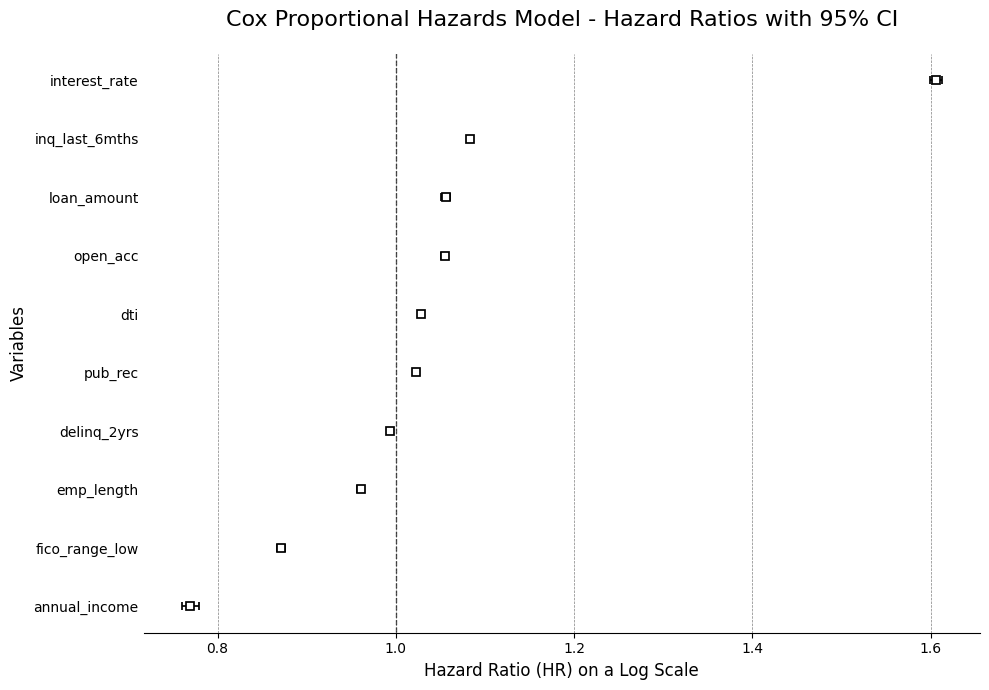

In [57]:
# =============================================================================
# CORRECTED AND STYLED PLOT 47: Cox Proportional Hazards Model
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from sklearn.preprocessing import StandardScaler

# --- Data Preparation and Model Fitting (same as before) ---
cox_data = survival_df[['time_to_event', 'event', 'loan_amount', 'interest_rate', 
                       'annual_income', 'dti', 'delinq_2yrs', 'fico_range_low', 
                       'inq_last_6mths', 'open_acc', 'pub_rec', 'emp_length']].copy()
cox_data = cox_data.dropna()

features_to_scale = ['loan_amount', 'interest_rate', 'annual_income', 'dti', 
                     'delinq_2yrs', 'fico_range_low', 'inq_last_6mths', 
                     'open_acc', 'pub_rec', 'emp_length']
scaler = StandardScaler()
scaled_cox_data = cox_data.copy()
scaled_cox_data[features_to_scale] = scaler.fit_transform(cox_data[features_to_scale])

cph = CoxPHFitter()
cph.fit(scaled_cox_data, duration_col='time_to_event', event_col='event')


# --- FIX AND STYLING START ---

# 1. Create the plot with hazard_ratios=True
fig, ax = plt.subplots(figsize=(10, 7))
cph.plot(hazard_ratios=True, ax=ax)

# 2. Prepare a list of colors based on the hazard ratios
hazard_ratios = cph.hazard_ratios_
# The hazard ratios from cph.plot are typically ordered from bottom to top on the y-axis,
# so we reverse the order of the ratios to match the markers.
colors = ['red' if hr > 1 else 'blue' for hr in reversed(hazard_ratios.values)]

# 3. Access the SINGLE collection of markers and set their colors all at once
# Check that a collection exists to be safe
if ax.collections:
    # ax.collections[0] is the collection of all the square markers
    marker_collection = ax.collections[0]
    marker_collection.set_color(colors)
    marker_collection.set_edgecolor('black') # Add a black edge for better visibility

# 4. Customize the rest of the plot aesthetics
ax.set_title("Cox Proportional Hazards Model - Hazard Ratios with 95% CI", fontsize=16, pad=20)
ax.set_xlabel("Hazard Ratio (HR) on a Log Scale", fontsize=12)
ax.set_ylabel("Variables", fontsize=12)

# Set a clean plot style
ax.grid(True, which='major', axis='x', linestyle='--', linewidth='0.5', color='grey')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', length=0) # Remove y-axis ticks

# Ensure the layout is tight
plt.tight_layout()
plt.show()

In [58]:
# =============================================================================
# CORRECTED PLOT 48: Risk Score Distribution Evolution
# =============================================================================

# --- FIX START ---
# Use the SCALED data to make predictions, as the model was trained on it.
# The features for prediction must match the features used in training.
features_to_predict = scaled_cox_data.drop(['time_to_event', 'event'], axis=1)
risk_scores = cph.predict_partial_hazard(features_to_predict)

# Create a new DataFrame for plotting to keep things clean.
# Use the index to align risk scores with their original loan age.
plot_df = pd.DataFrame({
    'risk_score': risk_scores,
    'loan_age_months': cox_data['time_to_event'] # Get age from original unscaled data
})
# --- FIX END ---


# Create age bins (this part was already correct)
age_bins = [0, 12, 24, 36, 48, 60, np.inf] # Use np.inf for the last bin edge
age_labels = ['0-12', '12-24', '24-36', '36-48', '48-60', '60+']
plot_df['age_category'] = pd.cut(plot_df['loan_age_months'], bins=age_bins, labels=age_labels, right=False)

fig = go.Figure()

age_colors = ['#3498DB', '#E74C3C', '#2ECC71', '#F39C12', '#9B59B6', '#34495E']

for i, age_cat in enumerate(age_labels):
    # Filter the new plot_df
    age_data = plot_df[plot_df['age_category'] == age_cat]['risk_score'].dropna()
    if not age_data.empty:
        fig.add_trace(go.Violin(
            y=age_data,
            name=f'{age_cat} months',
            box_visible=True, # Show box plot inside for more detail
            meanline_visible=True, # Show the mean line
            points='all', # Show individual data points
            jitter=0.05,
            side='positive',
            fillcolor=age_colors[i],
            line_color='black',
            opacity=0.7
        ))

fig.update_layout(
    title='Risk Score Distribution Evolution by Loan Age',
    xaxis_title='Loan Age Category',
    yaxis_title='Risk Score (on a Log Scale)',
    template="plotly_white",
    height=600,
    # --- OPTIONAL BUT RECOMMENDED IMPROVEMENT ---
    # Use a log scale on the y-axis to better visualize the skewed distribution
    yaxis_type="log"
)

# Hide the default x-axis tick labels if we are using violin plots per category
fig.update_xaxes(showticklabels=False)
fig.show()

In [59]:
# =============================================================================
# PLOT 49: Survival Probability Dashboard by Region
# =============================================================================

regional_survival = []

for region in regions:
    region_data = survival_df[survival_df['region'] == region]
    if len(region_data) > 0:
        kmf = KaplanMeierFitter()
        kmf.fit(region_data['time_to_event'], event_observed=region_data['event'])
        
        # Get survival probabilities at key time points
        survival_12m = kmf.survival_function_at_times(12).values[0] if 12 <= region_data['time_to_event'].max() else 1.0
        survival_24m = kmf.survival_function_at_times(24).values[0] if 24 <= region_data['time_to_event'].max() else 1.0
        survival_36m = kmf.survival_function_at_times(36).values[0] if 36 <= region_data['time_to_event'].max() else 1.0
        
        regional_survival.append({
            'region': region,
            'survival_12m': survival_12m * 100,
            'survival_24m': survival_24m * 100,
            'survival_36m': survival_36m * 100
        })

regional_survival_df = pd.DataFrame(regional_survival)

fig = go.Figure()

time_periods = ['12 Months', '24 Months', '36 Months']
survival_cols = ['survival_12m', 'survival_24m', 'survival_36m']

for i, period in enumerate(time_periods):
    fig.add_trace(go.Bar(
        x=regional_survival_df['region'].to_numpy(),
        y=regional_survival_df[survival_cols[i]].to_numpy(),
        name=period,
        marker_color=colors[i % len(colors)]
    ))

fig.update_layout(
    title='Survival Probability Dashboard by Region',
    xaxis_title='Region',
    yaxis_title='Survival Probability (%)',
    barmode='group',
    template="plotly_white",
    height=500
)

fig.show()

In [60]:
# =============================================================================
# PLOT 50: Time-to-Default Prediction Surface (With Non-Linearity)
# =============================================================================
from sklearn.preprocessing import PolynomialFeatures

# --- STEP 1: Engineer a Non-Linear Feature ---
# Create an interaction term to allow the model to learn a curved surface.
cox_data['fico_x_dti'] = cox_data['fico_range_low'] * cox_data['dti']

print("Re-fitting Cox Proportional Hazards model with interaction term...")

# --- STEP 2: Re-Fit the Model with the New Feature ---
# We need to re-train the cph model so it learns a weight for our new feature.
# Drop any rows with NaNs that might have been created
cox_data_interaction = cox_data.dropna()

cph_interactive = CoxPHFitter()
# Use the new DataFrame with the interaction term for fitting
cph_interactive.fit(cox_data_interaction, duration_col='time_to_event', event_col='event')

print("Model re-fitted. Creating prediction surface...")


# --- STEP 3: Create Prediction Data (Optimized) ---
# This part remains the same, but we must add the interaction term to our grid.
fico_range = np.linspace(survival_df['fico_range_low'].dropna().min(), survival_df['fico_range_low'].dropna().max(), 20)
dti_range = np.linspace(survival_df['dti'].dropna().min(), survival_df['dti'].dropna().max(), 20)
fico_mesh, dti_mesh = np.meshgrid(fico_range, dti_range)

# Select only numeric columns for the median calculation
numeric_cox_data = cox_data_interaction.select_dtypes(include=np.number).drop(['time_to_event', 'event'], axis=1)
median_row = numeric_cox_data.median()

rows_to_append = []
for i in range(len(fico_range)):
    for j in range(len(dti_range)):
        pred_row = median_row.copy()
        pred_row['fico_range_low'] = fico_mesh[j, i]
        pred_row['dti'] = dti_mesh[j, i]
        # Calculate the interaction term for the grid point
        pred_row['fico_x_dti'] = pred_row['fico_range_low'] * pred_row['dti']
        rows_to_append.append(pred_row)

prediction_data = pd.DataFrame(rows_to_append)
# Ensure columns match the newly trained model
prediction_data = prediction_data[cph_interactive.params_.index]


# --- STEP 4: Predict and Plot ---
# Use the NEW interactive model to predict
hazard_predictions = cph_interactive.predict_partial_hazard(prediction_data)
hazard_surface = hazard_predictions.values.reshape(len(dti_range), len(fico_range))

fig = go.Figure(data=[go.Surface(
    z=hazard_surface,
    x=fico_range,
    y=dti_range,
    colorscale='Reds',
    connectgaps=False
)])

fig.update_layout(
    title='Default Risk Surface: FICO Score vs DTI Ratio (with Interaction)',
    scene=dict(
        xaxis_title='FICO Score',
        yaxis_title='DTI Ratio',
        zaxis_title='Relative Hazard',
        camera=dict(eye=dict(x=1.2, y=1.2, z=1.2))
    ),
    height=600
)

fig.show()

Re-fitting Cox Proportional Hazards model with interaction term...
Model re-fitted. Creating prediction surface...


In [61]:
# =============================================================================
# PLOT 51: Conditional Survival Analysis
# =============================================================================

# Calculate conditional survival probabilities
conditional_survival_data = []

for grade in grades:
    grade_data = survival_df[survival_df['grade'] == grade]
    if len(grade_data) > 0:
        kmf = KaplanMeierFitter()
        kmf.fit(grade_data['time_to_event'], event_observed=grade_data['event'])
        
        # Given survival to 12 months, probability of surviving additional 12, 24, 36 months
        if 12 <= grade_data['time_to_event'].max():
            survival_12 = kmf.survival_function_at_times(12).values[0]
            
            for additional_months in [12, 24, 36]:
                target_time = 12 + additional_months
                if target_time <= grade_data['time_to_event'].max():
                    survival_target = kmf.survival_function_at_times(target_time).values[0]
                    conditional_prob = survival_target / survival_12 if survival_12 > 0 else 0
                else:
                    conditional_prob = 0
                
                conditional_survival_data.append({
                    'grade': grade,
                    'additional_months': additional_months,
                    'conditional_probability': conditional_prob * 100
                })

conditional_df = pd.DataFrame(conditional_survival_data)

fig = go.Figure()

for additional in [12, 24, 36]:
    additional_data = conditional_df[conditional_df['additional_months'] == additional]
    fig.add_trace(go.Bar(
        x=additional_data['grade'].to_numpy(),
        y=additional_data['conditional_probability'].to_numpy(),
        name=f'Additional {additional} months',
        opacity=0.8
    ))

fig.update_layout(
    title='Conditional Survival Probability<br>(Given Survival to 12 Months)',
    xaxis_title='Credit Grade',
    yaxis_title='Conditional Survival Probability (%)',
    barmode='group',
    template="plotly_white",
    height=500
)

fig.show()

In [62]:
# =============================================================================
# PLOT 52: Portfolio Survival Monitor (Final Corrected Version)
# =============================================================================
import numpy as np # Ensure numpy is imported
from lifelines import KaplanMeierFitter # Ensure fitter is imported

print("Optimizing portfolio survival calculation...")

# Real-time portfolio monitoring dashboard
current_portfolio = survival_df[survival_df['event'] == 0].copy()

# --- OPTIMIZATION START ---

# 1. Pre-fit one Kaplan-Meier model for each credit grade.
kmf_models = {}
grades = sorted(survival_df['grade'].unique())

print("Pre-fitting survival models for each grade...")
for grade in grades:
    grade_data = survival_df[survival_df['grade'] == grade]
    if not grade_data.empty:
        kmf = KaplanMeierFitter()
        kmf.fit(grade_data['time_to_event'], event_observed=grade_data['event'])
        kmf_models[grade] = kmf

print("Models fitted. Calculating expected defaults...")

# 2. Initialize the new column.
current_portfolio['expected_defaults_12m'] = np.nan

# 3. Loop through the pre-fitted models and apply them to the correct data slice.
for grade, kmf in kmf_models.items():
    grade_mask = current_portfolio['grade'] == grade
    if grade_mask.sum() == 0:
        continue

    current_age = current_portfolio.loc[grade_mask, 'time_to_event']
    future_time = current_age + 12
    
    current_survival_series = kmf.predict(current_age)
    future_survival_series = kmf.predict(future_time)
    
    # --- THE FIX: Convert Series to numpy arrays using .values ---
    # This bypasses the pandas index alignment that causes the error.
    current_survival_arr = current_survival_series.values
    future_survival_arr = future_survival_series.values
    
    # Perform the division on the raw numpy arrays.
    conditional_survival = np.divide(future_survival_arr, current_survival_arr, 
                                     out=np.ones_like(future_survival_arr), 
                                     where=current_survival_arr != 0)
    
    prob_default_12m = 1 - conditional_survival
    
    # Assign the results (a numpy array) directly back. .loc handles the alignment correctly here.
    current_portfolio.loc[grade_mask, 'expected_defaults_12m'] = prob_default_12m

# --- OPTIMIZATION END ---

print("Calculation complete. Aggregating for plot...")

# Aggregate by grade (using the correct column name 'funded_amnt')
portfolio_risk = current_portfolio.groupby('grade').agg({
    'funded_amount': 'sum',
    'expected_defaults_12m': 'mean'
}).reset_index()

portfolio_risk['expected_loss_amount'] = portfolio_risk['funded_amount'] * portfolio_risk['expected_defaults_12m']

# --- Plotting Code (remains the same) ---
fig = go.Figure()

fig.add_trace(go.Bar(
    x=portfolio_risk['grade'].to_numpy(),
    y=portfolio_risk['funded_amount'].to_numpy(),
    name='Portfolio Size',
    marker_color='lightblue', yaxis='y', opacity=0.7
))

fig.add_trace(go.Scatter(
    x=portfolio_risk['grade'].to_numpy(),
    y=portfolio_risk['expected_loss_amount'].to_numpy(),
    mode='lines+markers', name='Expected Loss (12m)',
    marker_color='red', yaxis='y2', line=dict(width=3)
))

fig.update_layout(
    title='Portfolio Survival Monitor: Current Risk Assessment',
    xaxis_title='Credit Grade',
    yaxis=dict(title='Portfolio Size (USD)', side='left'),
    yaxis2=dict(title='Expected Loss Amount (USD)', side='right', overlaying='y'),
    template="plotly_white",
    height=500
)

fig.show()

print("Phase 11 completed successfully")

Optimizing portfolio survival calculation...
Pre-fitting survival models for each grade...
Models fitted. Calculating expected defaults...
Calculation complete. Aggregating for plot...


Phase 11 completed successfully


In [63]:
# =============================================================================
# FINAL SUMMARY STATISTICS (Corrected)
# =============================================================================

print("\n" + "="*50)
print("ANALYSIS COMPLETE - SUMMARY STATISTICS")
print("="*50)

# The 'issue_d' column is now a datetime object, so we format it for clean printing.
print(f"Total Loans Analyzed: {len(df):,}")
print(f"Date Range: {df['issue_d'].min().strftime('%b-%Y')} to {df['issue_d'].max().strftime('%b-%Y')}")

# Use the correct column names from the Parquet file.
print(f"Total Loan Amount: ${df['loan_amount'].sum():,.0f}")
print(f"Average Interest Rate: {df['interest_rate'].mean():.2f}%")
print(f"Overall Bad Loan Rate in Dataset: {(df['loan_condition_int'].sum() / len(df) * 100):.2f}%")

print(f"\nRegional Distribution:")
# The 'regions' variable was defined in Plot 12.
for region in regions:
    count = len(df[df['region'] == region])
    percentage = (count / len(df)) * 100
    print(f"  {region}: {count:,} loans ({percentage:.1f}%)")

print(f"\nCredit Grade Distribution:")
# This works correctly on the categorical 'grade' column.
grades_list = [str(g) for g in df['grade'].unique() if pd.notna(g)]
for grade in sorted(grades_list):
    count = len(df[df['grade'] == grade])
    percentage = (count / len(df)) * 100
    default_rate = df[df['grade'] == grade]['loan_condition_int'].mean() * 100
    print(f"  Grade {grade}: {count:,} loans ({percentage:.1f}%) - Default Rate: {default_rate:.2f}%")

print(f"\nRisk-Adjusted Performance:")
print(f"Average RAROA: {df['raroa'].mean():.2%}")
print(f"Total Portfolio EVA: ${df['eva'].sum():,.0f}")

print(f"\nSurvival Analysis Results:")
# This calculation is based on the filtered 'survival_df' used for the model.
print(f"Median Time to Default (for defaulted loans): {survival_df[survival_df['event'] == 1]['time_to_event'].median():.1f} months")
# This calculates the overall survival rate within the survival analysis subset.
print(f"Overall Survival Rate in Survival Cohort: {(1 - survival_df['event'].mean()) * 100:.1f}%")

print("\n" + "="*50)
print("END OF COMPREHENSIVE LENDING CLUB RISK ANALYSIS")
print("="*50)


ANALYSIS COMPLETE - SUMMARY STATISTICS
Total Loans Analyzed: 2,260,701
Date Range: Jun-2007 to Dec-2018
Total Loan Amount: $34,016,115,925
Average Interest Rate: 13.09%
Overall Bad Loan Rate in Dataset: 13.43%

Regional Distribution:
  MidWest: 403,150 loans (17.8%)
  NorthEast: 519,095 loans (23.0%)
  SouthEast: 550,165 loans (24.3%)
  SouthWest: 272,789 loans (12.1%)
  West: 515,469 loans (22.8%)

Credit Grade Distribution:
  Grade A: 433,027 loans (19.2%) - Default Rate: 3.81%
  Grade B: 663,557 loans (29.4%) - Default Rate: 9.07%
  Grade C: 650,053 loans (28.8%) - Default Rate: 15.05%
  Grade D: 324,424 loans (14.4%) - Default Rate: 21.24%
  Grade E: 135,639 loans (6.0%) - Default Rate: 29.17%
  Grade F: 41,800 loans (1.8%) - Default Rate: 37.31%
  Grade G: 12,168 loans (0.5%) - Default Rate: 41.17%

Risk-Adjusted Performance:
Average RAROA: 11.11%
Total Portfolio EVA: $203,555,457

Survival Analysis Results:
Median Time to Default (for defaulted loans): 14.0 months
Overall Surviv